In this notebook, data about international student mobility will be processed and cleaned.

In [11]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from iso3166 import countries

In [13]:
# This is a dictionary for countries that are not in the iso3166 library.
countries_map = {'Tanzania': 'TZA', 'Congo, Republic of the (Brazzaville)':'COG', 'Congo, Dem. Rep. of the (Kinshasa)' : 'COD', 
                 'São Tomé & Príncipe': 'STP', 'Reunion': 'REU', 'Côte d’Ivoire': 'CIV', 'Gambia, The': 'GMB', 'Saint Helena': 'SHN', 
                 'Macau': 'MAC', 'North Korea': 'PRK', 'South Korea': 'KOR', 'Brunei': 'BRN', 'Burma/Myanmar': 'MMR', 'Laos': 'LAO', 
                 'Vietnam': 'VNM', 'Czechia/Czech Republic': 'CZE', 'Czechoslovakia, Former': 'CSK', 'Moldova': 'MDA', 'Russia': 'RUS',
                 'Serbia & Montenegro': 'SCG', 'Turkey': 'TUR', 'U.S.S.R., Former': 'SUN', 'Yugoslavia, Former': 'YUG', 'United Kingdom': 'GBR',
                 'British Virgin Islands': 'VGB', 'Curacao': 'CUW', 'Netherlands Antilles': 'ANT', 'St. Kitts and Nevis': 'KNA', 'St. Lucia': 'LCA',
                 'St. Vincent and the Grenadines': 'VCT', 'Stateless': 'Stateless', 'Sint Maarten': 'SXM', 'Turks and Caicos': 'TCA', 'Bolivia': 'BOL',
                 'Falkland Islands/Islas Malvinas': 'FLK', 'Venezuela': 'VEN', 'Iran': 'IRN', 'Palestinian Territories': 'PSE', 'Syria': 'SYR',
                 'Marshall Islands, Republic of the': 'MHL', 'Micronesia, Federate States of': 'FSM'}

In [2]:
# Load the data
female_eu_data = pd.read_csv("data/female eu data.csv")
male_eu_data = pd.read_csv("data/male data eu.csv")

In [3]:
# Drop columns that are not needed/irrelevant
female_eu_data.drop(columns=['OBS_FLAG', 'STRUCTURE', 'STRUCTURE_ID', 'isced11', 'freq'], inplace=True)
male_eu_data.drop(columns=['OBS_FLAG', 'STRUCTURE', 'STRUCTURE_ID', 'isced11', 'freq'], inplace=True)

In [5]:
# The values representing the number of students were stored as strings, so we need to convert them to integers.
def convert_to_num(value):
    if np.isnan(value):
        value = np.nan_to_num(value)
    return int(value)
female_eu_data['OBS_VALUE'] = female_eu_data['OBS_VALUE'].apply(convert_to_num)
male_eu_data['OBS_VALUE'] = male_eu_data['OBS_VALUE'].apply(convert_to_num)

In [7]:
# Get the log of each value to look at the distribution of the data.
def calculate_log_value(value):
    if value == 0:
        return 0
    try:
        return int(np.log(value))
    except:
        print(value, type(value))
        return 0

log_freq_fem = {} # log frequency of female
log_freq_mal = {} # log frequency of male

for i, row in female_eu_data.iterrows():
    val = calculate_log_value(row['OBS_VALUE'])
    if val not in log_freq_fem:
        log_freq_fem[val] = 0
    log_freq_fem[val] += 1

for i, row in male_eu_data.iterrows():
    val = calculate_log_value(row['OBS_VALUE'])
    if val not in log_freq_mal:
        log_freq_mal[val] = 0
    log_freq_mal[val] += 1

/var/folders/jp/bdm9xg0d6870cmmvqmgc1sgw0000gn/T/ipykernel_50802/1786238466.py:5: RuntimeWarning: invalid value encountered in log
  return int(np.log(value))


-1 <class 'int'>


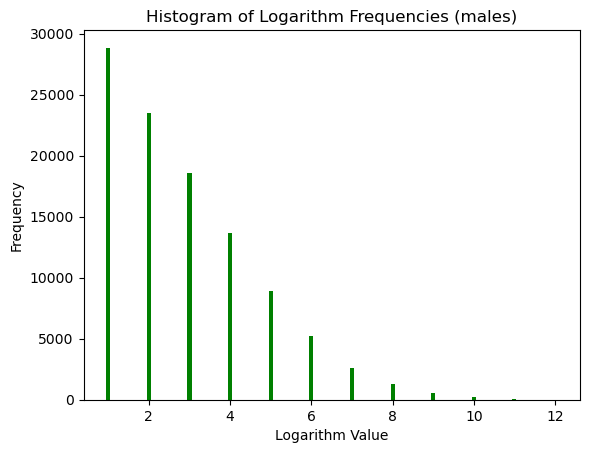

In [9]:
# This is plotted in order to have an understanding whether the numbers "make sense" or not.

plt.bar(list(log_freq_mal.keys())[1:], list(log_freq_mal.values())[1:], width=0.1, color='g')
plt.xlabel('Logarithm Value')
plt.ylabel('Frequency')
plt.title('Histogram of Logarithm Frequencies (males)')
plt.show()

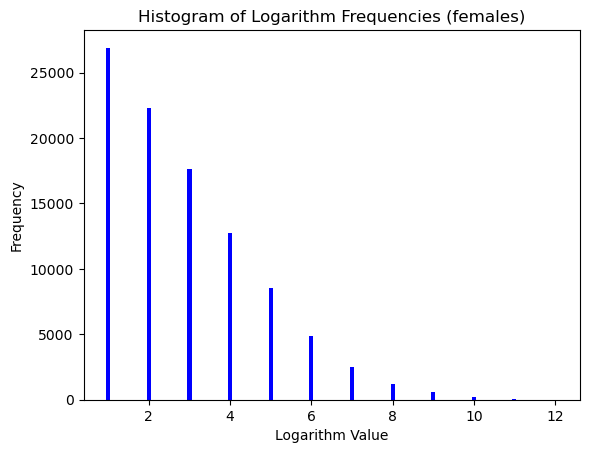

In [10]:
# This is plotted in order to have an understanding whether the numbers "make sense" or not.
plt.bar(list(log_freq_fem.keys())[1:], list(log_freq_fem.values())[1:], width=0.1, color='b')
plt.xlabel('Logarithm Value')
plt.ylabel('Frequency')
plt.title('Histogram of Logarithm Frequencies (females)')
plt.show()

In [15]:
# Converting the country names to their alpha3 codes for easier processing. For example, 'UK' is converted to 'GBR', FR is converted to 'FRA' etc.
def convert_to_alpha3(value):
    try:
        value = value.strip()
        if value == 'UK':
            return 'GBR'
        if value == 'AME_N':
            return 'NorthERN America [COUNTRY NOT SPECIFIED]'
        if value == 'AFR':
            return 'Africa [COUNTRY NOT SPECIFIED]'
        if value == 'AME_X_N':
            return 'Caribbean, Central and Southenr America [COUNTRY NOT SPECIFIED]'
        if value == 'ASI':
            return 'ASIA [COUNTRY NOT SPECIFIED]'
        if value == 'EL':
            return countries.get('Greece').alpha3
        if value == 'OCE':
            return 'OCE [COUNTRY NOT SPECIFIED]'
        if value == 'WRL_X_REP':
            return 'World total except for the reporting country [COUNTRY NOT SPECIFIED]'
        if type(value) == float:
            return 'NAN [COUNTRY NOT SPECIFIED]'
        if value in countries_map:
            return countries_map[value]
        return countries.get(value).alpha3
    except:
        return 'COULD NOT CONVERT'
    
female_eu_data['partner'] = female_eu_data['partner'].apply(convert_to_alpha3)
female_eu_data['geo'] = female_eu_data['geo'].apply(convert_to_alpha3)
male_eu_data['partner'] = male_eu_data['partner'].apply(convert_to_alpha3)
male_eu_data['geo'] = male_eu_data['geo'].apply(convert_to_alpha3)

In [16]:
# Defining the years and the graphs

years = [i for i in range(2013,2023)]
years_graph = {
    2013: nx.DiGraph(),
    2014: nx.DiGraph(),
    2015: nx.DiGraph(),
    2016: nx.DiGraph(),
    2017: nx.DiGraph(),
    2018: nx.DiGraph(),
    2019: nx.DiGraph(),
    2020: nx.DiGraph(),
    2021: nx.DiGraph(),
    2022: nx.DiGraph()
}
edges_for_graphs = [[] for i in range(len(years))] # This is for total: male and female
edges_for_graphs_female = [[] for i in range(len(years))]
edges_for_graphs_male = [[] for i in range(len(years))]
years_graph_male = {
    2013: nx.DiGraph(),
    2014: nx.DiGraph(),
    2015: nx.DiGraph(),
    2016: nx.DiGraph(),
    2017: nx.DiGraph(),
    2018: nx.DiGraph(),
    2019: nx.DiGraph(),
    2020: nx.DiGraph(),
    2021: nx.DiGraph(),
    2022: nx.DiGraph()
}

years_graph_female = {
    2013: nx.DiGraph(),
    2014: nx.DiGraph(),
    2015: nx.DiGraph(),
    2016: nx.DiGraph(),
    2017: nx.DiGraph(),
    2018: nx.DiGraph(),
    2019: nx.DiGraph(),
    2020: nx.DiGraph(),
    2021: nx.DiGraph(),
    2022: nx.DiGraph()
}

In [21]:
# This is for the total number of students, gender not considered.
origin_dist_value = [dict() for i in range(2013, 2023)]

for i, row in female_eu_data.iterrows():
    key = row['partner'] + '-' +  row['geo']
    value = row['OBS_VALUE']
    index = years.index(int(row['TIME_PERIOD']))
    if key not in origin_dist_value[index]:
        origin_dist_value[index][key] = 0
    origin_dist_value[index][key] += value


for i, row in male_eu_data.iterrows():
    key = row['partner'] + '-' +  row['geo']
    value = row['OBS_VALUE']
    index = years.index(int(row['TIME_PERIOD']))
    if key not in origin_dist_value[index]:
        origin_dist_value[index][key] = 0
    origin_dist_value[index][key] += value

print(len(origin_dist_value))

10


In [22]:
# Populating the edges for the graphs.
for i in range(len(origin_dist_value)):
    dictionary = origin_dist_value[i]
    for key, value in dictionary.items():
        key = key.split('-')
        origin = key[0]
        destination = key[1]
        value = value
        data = {'origin': origin, 'destination': destination, 'value': value}
        edges = []
        if (origin not in list(female_eu_data['geo'].unique()) or value == 0):
            continue
        else:
            edges_for_graphs[i].append(data)

In [23]:
# Defining the graphs that are not normalised.
year_graph_female_not_normal = {
    2013: nx.DiGraph(),
    2014: nx.DiGraph(),
    2015: nx.DiGraph(),
    2016: nx.DiGraph(),
    2017: nx.DiGraph(),
    2018: nx.DiGraph(),
    2019: nx.DiGraph(),
    2020: nx.DiGraph(),
    2021: nx.DiGraph(),
    2022: nx.DiGraph()
}

year_graph_not_normal = {
    2013: nx.DiGraph(),
    2014: nx.DiGraph(),
    2015: nx.DiGraph(),
    2016: nx.DiGraph(),
    2017: nx.DiGraph(),
    2018: nx.DiGraph(),
    2019: nx.DiGraph(),
    2020: nx.DiGraph(),
    2021: nx.DiGraph(),
    2022: nx.DiGraph()
}

year_graph_male_not_normal = {
    2013: nx.DiGraph(),
    2014: nx.DiGraph(),
    2015: nx.DiGraph(),
    2016: nx.DiGraph(),
    2017: nx.DiGraph(),
    2018: nx.DiGraph(),
    2019: nx.DiGraph(),
    2020: nx.DiGraph(),
    2021: nx.DiGraph(),
    2022: nx.DiGraph()
}

In [24]:
# Separating by gender
origin_dist_value = {}
female_data = {}
male_data = {}

for i, row in female_eu_data.iterrows():
    key = row['partner'] + '-' +  row['geo'] + '-' + str(row['TIME_PERIOD'])
    value = row['OBS_VALUE']
    
    if key not in origin_dist_value:
        origin_dist_value[key] = 0
        female_data[key] = 0
  
    origin_dist_value[key] += value
    female_data[key] += value


for i, row in male_eu_data.iterrows():
    key = row['partner'] + '-' +  row['geo'] + '-' +str(row['TIME_PERIOD'])
    value = row['OBS_VALUE']

    if key not in origin_dist_value:
        origin_dist_value[key] = 0
    if key not in male_data:
        male_data[key] = 0

    male_data[key] += value
    origin_dist_value[key] += value

for key, value in female_data.items():
    key = key.split('-')
    origin = key[0]
    destination = key[1]
    year = int(key[2])
    value = value
    data = {'origin': origin, 'destination': destination, 'value': value}
    edges = []
    if (origin not in list(female_eu_data['geo'].unique()) or value == 0):
        continue
    edges_for_graphs_female[years.index(year)].append(data)

for key, value in male_data.items():
    key = key.split('-')
    origin = key[0]
    destination = key[1]
    year = int(key[2])
    value = value
    data = {'origin': origin, 'destination': destination, 'value': value}
    edges = []
    if (origin not in list(female_eu_data['geo'].unique()) or value == 0):
        continue
    edges_for_graphs_male[years.index(year)].append(data)

In [29]:
# Normalising the weights of the graphs.
def normalize_weights(graph):
    max_weight = max([d['weight'] for u, v, d in graph.edges(data=True)], default=1)
    if max_weight > 0:
        for u, v, d in graph.edges(data=True):
            d['weight'] /= max_weight

for i in range(len(years)):
    year = str(years[i])

    year_graph = nx.DiGraph()
    for edge in edges_for_graphs[i]:
        year_graph.add_edge(edge['origin'], edge['destination'], weight=edge['value'])
    normalize_weights(year_graph)
    years_graph[year] = year_graph
    nx.write_gexf(year_graph, f'{year}-total.gexf')
    print("Saved " + year + "-total.gexf")

    year_graph_female = nx.DiGraph()
    for edge in edges_for_graphs_female[i]:
        year_graph_female.add_edge(edge['origin'], edge['destination'], weight=edge['value'])
    normalize_weights(year_graph_female)
    years_graph_female[year] = year_graph_female
    nx.write_gexf(year_graph_female, f'{year}-female.gexf')
    print("Saved " + year + "-female.gexf")

    year_graph_male = nx.DiGraph()
    for edge in edges_for_graphs_male[i]:
        year_graph_male.add_edge(edge['origin'], edge['destination'], weight=edge['value'])
    normalize_weights(year_graph_male)
    years_graph_male[year] = year_graph_male
    nx.write_gexf(year_graph_male, f'{year}-male.gexf')
    print("Saved " + year + "-male.gexf")

Saved 2013-total.gexf
Saved 2013-female.gexf
Saved 2013-male.gexf
Saved 2014-total.gexf
Saved 2014-female.gexf
Saved 2014-male.gexf
Saved 2015-total.gexf
Saved 2015-female.gexf
Saved 2015-male.gexf
Saved 2016-total.gexf
Saved 2016-female.gexf
Saved 2016-male.gexf
Saved 2017-total.gexf
Saved 2017-female.gexf
Saved 2017-male.gexf
Saved 2018-total.gexf
Saved 2018-female.gexf
Saved 2018-male.gexf
Saved 2019-total.gexf
Saved 2019-female.gexf
Saved 2019-male.gexf
Saved 2020-total.gexf
Saved 2020-female.gexf
Saved 2020-male.gexf
Saved 2021-total.gexf
Saved 2021-female.gexf
Saved 2021-male.gexf
Saved 2022-total.gexf
Saved 2022-female.gexf
Saved 2022-male.gexf


In [30]:
# Saving the graphs that are not normalised.
for i in range(len(years)):
    year = str(years[i])

    year_graph = nx.DiGraph()
    for edge in edges_for_graphs[i]:
        year_graph.add_edge(edge['origin'], edge['destination'], weight=edge['value'])
    nx.write_gexf(year_graph, year + '-total-not-normal.gexf')
    year_graph_not_normal[year] = year_graph
    print("Saved " + year + "-total-not-normal.gexf")

    year_graph_female = nx.DiGraph()
    for edge in edges_for_graphs_female[i]:
        year_graph_female.add_edge(edge['origin'], edge['destination'], weight=edge['value'])
    nx.write_gexf(year_graph_female, year + '-female-not-normal.gexf')
    year_graph_female_not_normal[year] = year_graph_female
    print("Saved " + year + "-female-not-normal.gexf")

    year_graph_male = nx.DiGraph()
    for edge in edges_for_graphs_male[i]:
        year_graph_male.add_edge(edge['origin'], edge['destination'], weight=edge['value'])
    nx.write_gexf(year_graph_male, year + '-male-not-normal.gexf')
    year_graph_male_not_normal[year] = year_graph_male
    print("Saved " + year + "-male-not-normal.gexf")

Saved 2013-total-not-normal.gexf
Saved 2013-female-not-normal.gexf
Saved 2013-male-not-normal.gexf
Saved 2014-total-not-normal.gexf
Saved 2014-female-not-normal.gexf
Saved 2014-male-not-normal.gexf
Saved 2015-total-not-normal.gexf
Saved 2015-female-not-normal.gexf
Saved 2015-male-not-normal.gexf
Saved 2016-total-not-normal.gexf
Saved 2016-female-not-normal.gexf
Saved 2016-male-not-normal.gexf
Saved 2017-total-not-normal.gexf
Saved 2017-female-not-normal.gexf
Saved 2017-male-not-normal.gexf
Saved 2018-total-not-normal.gexf
Saved 2018-female-not-normal.gexf
Saved 2018-male-not-normal.gexf
Saved 2019-total-not-normal.gexf
Saved 2019-female-not-normal.gexf
Saved 2019-male-not-normal.gexf
Saved 2020-total-not-normal.gexf
Saved 2020-female-not-normal.gexf
Saved 2020-male-not-normal.gexf
Saved 2021-total-not-normal.gexf
Saved 2021-female-not-normal.gexf
Saved 2021-male-not-normal.gexf
Saved 2022-total-not-normal.gexf
Saved 2022-female-not-normal.gexf
Saved 2022-male-not-normal.gexf


In [31]:
with open("edges-total.json", "w") as f:
    f.write(str(edges_for_graphs))

with open("edges-female.json", "w") as f:
    f.write(str(edges_for_graphs_female))
    
with open("edges-male.json","w") as f:
    f.write(str(edges_for_graphs_male))